## Delta[HHB2] Fitting

In [1]:
import pandas as pd
import glob
import os
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read Simulation data

In [3]:
csv_folder = '/content/drive/MyDrive/MCX_data/result_folder'
GT_folder = '/content/drive/MyDrive/MCX_data/csv'

In [4]:
csv_files = glob.glob(os.path.join(csv_folder, '*.csv'))
df_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [5]:
df_all.head()

,ID,Uac_1_1,Udc_1_1,Phase_1_1,Uac_1_2,Udc_1_2,Phase_1_2,Uac_1_3,Udc_1_3,Phase_1_3,...,Phase_4_5,Uac_4_6,Udc_4_6,Phase_4_6,Uac_4_7,Udc_4_7,Phase_4_7,Uac_4_8,Udc_4_8,Phase_4_8
0,1,0.000630,0.000665,-0.501516,0.000645,0.000680,-0.494211,0.000654,0.000687,-0.479320,...,-0.956285,0.000022,0.000024,-0.938081,0.000022,0.000024,-0.907132,0.000022,0.000024,-0.899211
1,2,0.000659,0.000704,-0.528213,0.000675,0.000720,-0.520862,0.000685,0.000727,-0.505208,...,-1.018659,0.000027,0.000030,-1.001600,0.000027,0.000030,-0.971622,0.000027,0.000030,-0.959532
2,3,0.000677,0.000730,-0.549963,0.000693,0.000747,-0.542363,0.000704,0.000755,-0.526124,...,-1.077448,0.000031,0.000035,-1.060109,0.000031,0.000035,-1.031858,0.000032,0.000035,-1.016267
3,4,0.000686,0.000749,-0.566580,0.000703,0.000766,-0.558862,0.000714,0.000773,-0.542014,...,-1.130043,0.000034,0.000039,-1.111908,0.000034,0.000039,-1.084599,0.000035,0.000040,-1.067255
4,5,0.000691,0.000761,-0.578840,0.000708,0.000778,-0.570998,0.000719,0.000785,-0.553765,...,-1.176073,0.000036,0.000042,-1.156740,0.000037,0.000043,-1.129599,0.000037,0.000043,-1.110989


In [6]:
csv_files = glob.glob(os.path.join(GT_folder, '*.csv'))
GT_all = pd.concat([pd.read_csv(f) for f in csv_files], ignore_index=True)

In [7]:
GT_all.head

<bound method NDFrame.head of           ID  HBO1  HHB1  HBO2  HHB2  Thickness  complete
0      43925  12.5   7.5    40    25         18     False
1      43926  12.5   7.5    40    25         20     False
2      43927  12.5   7.5    40    27         10     False
3      43928  12.5   7.5    40    27         12     False
4      43929  12.5   7.5    40    27         14     False
...      ...   ...   ...   ...   ...        ...       ...
87841  10977   6.5   6.5    28    21         14     False
87842  10978   6.5   6.5    28    21         16     False
87843  10979   6.5   6.5    28    21         18     False
87844  10980   6.5   6.5    28    21         20     False
87845  10981   6.5   6.5    28    23         10     False

[87846 rows x 7 columns]>

### Merge data

In [8]:
GT_all['ID'] = GT_all['ID'].astype(int)
df_all['ID'] = df_all['ID'].astype(int)
GT_all = GT_all.sort_values('ID').reset_index(drop=True)
df_all = df_all.sort_values('ID').reset_index(drop=True)

In [9]:
merged_df = pd.merge(df_all, GT_all, on='ID', how='inner')

In [10]:
merged_df.head

<bound method NDFrame.head of       ID   Uac_1_1   Udc_1_1  Phase_1_1   Uac_1_2   Udc_1_2  Phase_1_2  \
0      1  0.000630  0.000665  -0.501516  0.000645  0.000680  -0.494211   
1      2  0.000659  0.000704  -0.528213  0.000675  0.000720  -0.520862   
2      3  0.000677  0.000730  -0.549963  0.000693  0.000747  -0.542363   
3      4  0.000686  0.000749  -0.566580  0.000703  0.000766  -0.558862   
4      5  0.000691  0.000761  -0.578840  0.000708  0.000778  -0.570998   
..   ...       ...       ...        ...       ...       ...        ...   
155  156  0.000692  0.000766  -0.584238  0.000710  0.000784  -0.576365   
156  157  0.000611  0.000640  -0.482166  0.000627  0.000656  -0.475665   
157  158  0.000649  0.000687  -0.513365  0.000665  0.000703  -0.506709   
158  159  0.000671  0.000719  -0.538951  0.000688  0.000736  -0.531871   
159  160  0.000683  0.000741  -0.558647  0.000700  0.000758  -0.551327   

      Uac_1_3   Udc_1_3  Phase_1_3  ...  Phase_4_7   Uac_4_8   Udc_4_8  \
0    0.000654  0.000687  -0.479320  ...  -0.907132  0.000022  0.000024   
1    0.000685  0.000727  -0.505208  ...  -0.971622  0.000027  0.000030   
2    0.000704  0.000755  -0.526124  ...  -1.031858  0.000032  0.000035   
3    0.000714  0.000773  -0.542014  ...  -1.084599  0.000035  0.000040   
4    0.000719  0.000785  -0.553765  ...  -1.129599  0.000037  0.000043   
..        ...       ...        ...  ...        ...       ...       ...   
155  0.000721  0.000791  -0.559077  ...  -1.152303  0.000038  0.000045   
156  0.000636  0.000663  -0.462100  ...  -0.857792  0.000020  0.000021   
157  0.000675  0.000711  -0.492039  ...  -0.930810  0.000025  0.000027   
158  0.000698  0.000744  -0.516378  ...  -0.998481  0.000030  0.000033   
159  0.000711  0.000766  -0.534975  ...  -1.057558  0.000034  0.000038   

     Phase_4_8  HBO1  HHB1  HBO2  HHB2  Thickness  complete  
0    -0.899211   5.0   2.5    25    15         10     False  
1    -0.959532   5.0   2.5    25    15         12     False  
2    -1.016267   5.0   2.5    25    15         14     False  
3    -1.067255   5.0   2.5    25    15         16     False  
4    -1.110989   5.0   2.5    25    15         18     False  
..         ...   ...   ...   ...   ...        ...       ...  
155  -1.132938   5.0   2.5    31    21         20     False  
156  -0.853066   5.0   2.5    31    23         10     False  
157  -0.921109   5.0   2.5    31    23         12     False  
158  -0.984520   5.0   2.5    31    23         14     False  
159  -1.041142   5.0   2.5    31    23         16     False  

[160 rows x 103 columns]>

In [11]:
X = merged_df[df_all.columns.difference(['ID'])]
Y = merged_df[['HBO1', 'HHB1', 'HBO2', 'HHB2', 'Thickness']]

In [12]:
X

,Phase_1_1,Phase_1_2,Phase_1_3,Phase_1_4,Phase_1_5,Phase_1_6,Phase_1_7,Phase_1_8,Phase_2_1,Phase_2_2,...,Udc_3_7,Udc_3_8,Udc_4_1,Udc_4_2,Udc_4_3,Udc_4_4,Udc_4_5,Udc_4_6,Udc_4_7,Udc_4_8
0,-0.501516,-0.494211,-0.479320,-0.466597,-0.453209,-0.442392,-0.434354,-0.426198,-0.693509,-0.685174,...,0.000069,0.000069,0.000024,0.000026,0.000025,0.000025,0.000024,0.000024,0.000024,0.000024
1,-0.528213,-0.520862,-0.505208,-0.492353,-0.478282,-0.467212,-0.458873,-0.450206,-0.736003,-0.725650,...,0.000080,0.000081,0.000030,0.000032,0.000031,0.000031,0.000030,0.000030,0.000030,0.000030
2,-0.549963,-0.542363,-0.526124,-0.513049,-0.498408,-0.487087,-0.478677,-0.469506,-0.772475,-0.760532,...,0.000090,0.000091,0.000035,0.000037,0.000036,0.000036,0.000036,0.000035,0.000035,0.000035
3,-0.566580,-0.558862,-0.542014,-0.528792,-0.513907,-0.502234,-0.494043,-0.484335,-0.802565,-0.789521,...,0.000098,0.000099,0.000039,0.000041,0.000040,0.000040,0.000040,0.000039,0.000039,0.000040
4,-0.578840,-0.570998,-0.553765,-0.540315,-0.525392,-0.513456,-0.505478,-0.495419,-0.825953,-0.812318,...,0.000103,0.000105,0.000043,0.000045,0.000044,0.000044,0.000044,0.000042,0.000043,0.000043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,-0.584238,-0.576365,-0.559077,-0.545656,-0.530728,-0.518724,-0.510897,-0.500731,-0.836362,-0.822579,...,0.000106,0.000108,0.000044,0.000047,0.000045,0.000045,0.000045,0.000044,0.000045,0.000045
156,-0.482166,-0.475665,-0.462100,-0.450176,-0.437614,-0.427277,-0.419505,-0.411771,-0.660450,-0.654636,...,0.000062,0.000063,0.000020,0.000022,0.000021,0.000022,0.000021,0.000020,0.000020,0.000021
157,-0.513365,-0.506709,-0.492039,-0.479824,-0.466368,-0.455720,-0.447436,-0.439139,-0.709712,-0.701252,...,0.000075,0.000076,0.000026,0.000028,0.000028,0.000028,0.000028,0.000027,0.000027,0.000027
158,-0.538951,-0.531871,-0.516378,-0.503774,-0.489527,-0.478537,-0.470080,-0.461225,-0.752002,-0.741366,...,0.000086,0.000087,0.000032,0.000034,0.000033,0.000034,0.000033,0.000032,0.000032,0.000033


In [13]:
Y

,HBO1,HHB1,HBO2,HHB2,Thickness
0,5.0,2.5,25,15,10
1,5.0,2.5,25,15,12
2,5.0,2.5,25,15,14
3,5.0,2.5,25,15,16
4,5.0,2.5,25,15,18
...,...,...,...,...,...
155,5.0,2.5,31,21,20
156,5.0,2.5,31,23,10
157,5.0,2.5,31,23,12
158,5.0,2.5,31,23,14


In [14]:
X = X.to_numpy()
Y = Y.to_numpy()
Y = Y[:, 3]
Y = Y.reshape(-1, 1)

In [15]:
X.shape

(160, 96)

In [16]:
Y.shape

(160, 1)

### Create Data Pair: [X1 , X2] = Y1 - Y2

In [18]:
import numpy as np
from sklearn.model_selection import train_test_split

# Example data shapes
# X: (160, 96), Y: (160, 1)

# Step 1: Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

# Step 2: Pairing function
def generate_pairs(X1, Y1, X2=None, Y2=None):
    X_pairs = []
    Y_diffs = []

    if X2 is None:
        # Pair within the same set (X1 vs X1)
        for i in range(len(X1)):
            for j in range(len(X1)):
                x_pair = np.concatenate([X1[i], X1[j]])
                y_diff = Y1[i, 0] - Y1[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)
    else:
        # Pair across different sets (X1 vs X2)
        for i in range(len(X1)):
            for j in range(len(X2)):
                x_pair = np.concatenate([X1[i], X2[j]])
                y_diff = Y1[i, 0] - Y2[j, 0]
                X_pairs.append(x_pair)
                Y_diffs.append(y_diff)

    return np.array(X_pairs), np.array(Y_diffs).reshape(-1, 1)

# Step 3: Generate all combinations
X_train_pairs, Y_train_diffs = generate_pairs(X_train, Y_train)                    # train vs train
X_test_pairs, Y_test_diffs = generate_pairs(X_test, Y_test)                        # test vs test
X_cross_pairs, Y_cross_diffs = generate_pairs(X_train, Y_train, X_test, Y_test)    # train vs test

# Step 4: Print results
print("Train pairs:", X_train_pairs.shape, Y_train_diffs.shape)  # (144*144, 192)
print("Test pairs:", X_test_pairs.shape, Y_test_diffs.shape)     # (16*16, 192)
##print("Cross pairs:", X_cross_pairs.shape, Y_cross_diffs.shape)  # (144*16, 192)

Train pairs: (20736, 192) (20736, 1)
Test pairs: (256, 192) (256, 1)


### XGboost

In [19]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    max_depth=16,
    learning_rate=0.05,
    tree_method='gpu_hist',  # Enable GPU acceleration
    predictor='gpu_predictor'
)

model.fit(X_train_pairs, Y_train_diffs)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:46:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:46:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, predictor='gpu_predictor', ...)

In [20]:
y_preds = np.column_stack([model.predict(X_test_pairs)])
mse = np.mean((y_preds - Y_test_diffs)**2, axis=0)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:47:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:47:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


In [21]:
mse

array([15.84410298])

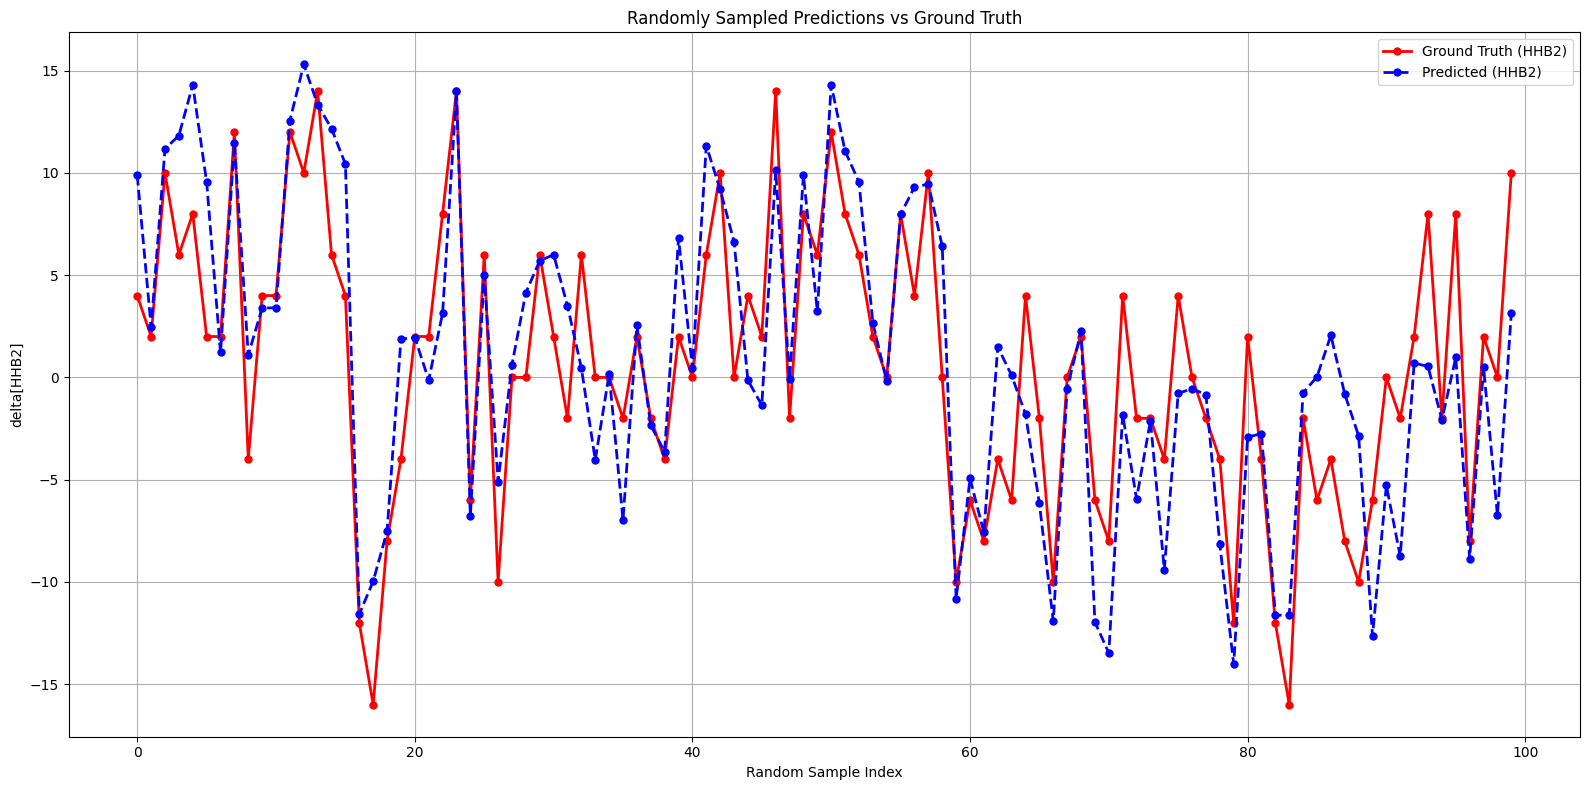

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure reproducibility
np.random.seed(42)

# Randomly select 100 indices
indices = np.random.choice(len(Y_test_diffs), size=100, replace=False)
indices = np.sort(indices)

# Extract corresponding values
y_test_sampled = Y_test_diffs[indices]
y_pred_sampled = y_preds[indices]
# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('delta[HHB2]')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

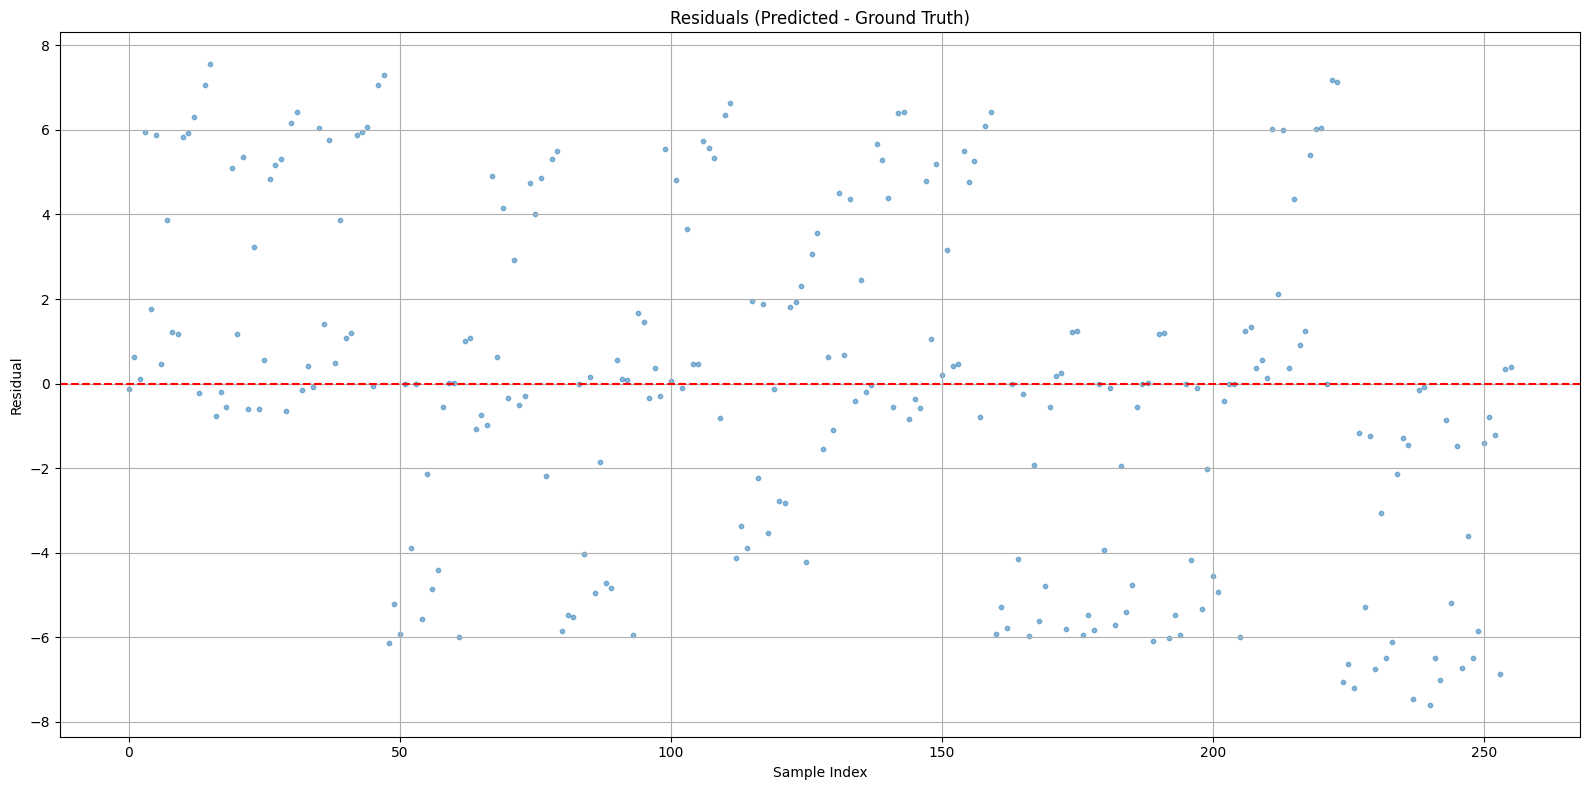

In [23]:
residuals = y_preds - Y_test_diffs

plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
X_train_pairs.shape

(20736, 192)

### ANN

In [27]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input


# Fit scaler on training targets only
scaler_y = StandardScaler()
y_train_s = scaler_y.fit_transform(Y_train_diffs)
y_test_s = scaler_y.transform(Y_test_diffs)

scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train_pairs)
X_test_s = scaler_X.transform(X_test_pairs)

# Define ANN model
model = Sequential([
    Input(shape=(192,)),
    Dense(192, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train_s, y_train_s, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Predict and evaluate
y_pred = model.predict(X_test_s)
mse = mean_squared_error(y_test_s, y_pred)
print(f"Test MSE: {mse:.4f}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


584/584 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.9614 - val_loss: 0.7798
Epoch 2/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.8354 - val_loss: 0.5596
Epoch 3/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5204 - val_loss: 0.2910
Epoch 4/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3036 - val_loss: 0.1758
Epoch 5/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1945 - val_loss: 0.1268
Epoch 6/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1345 - val_loss: 0.1142
Epoch 7/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1033 - val_loss: 0.0606
Epoch 8/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0811 - val_loss: 0.0599
Epoch 9/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0656 - val_loss: 0.0829
Epoch 10/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0610 - val_loss: 0.0425
Epoch 11/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0485 - val_loss: 0.0381
Epoch 12/100
584/584 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/st

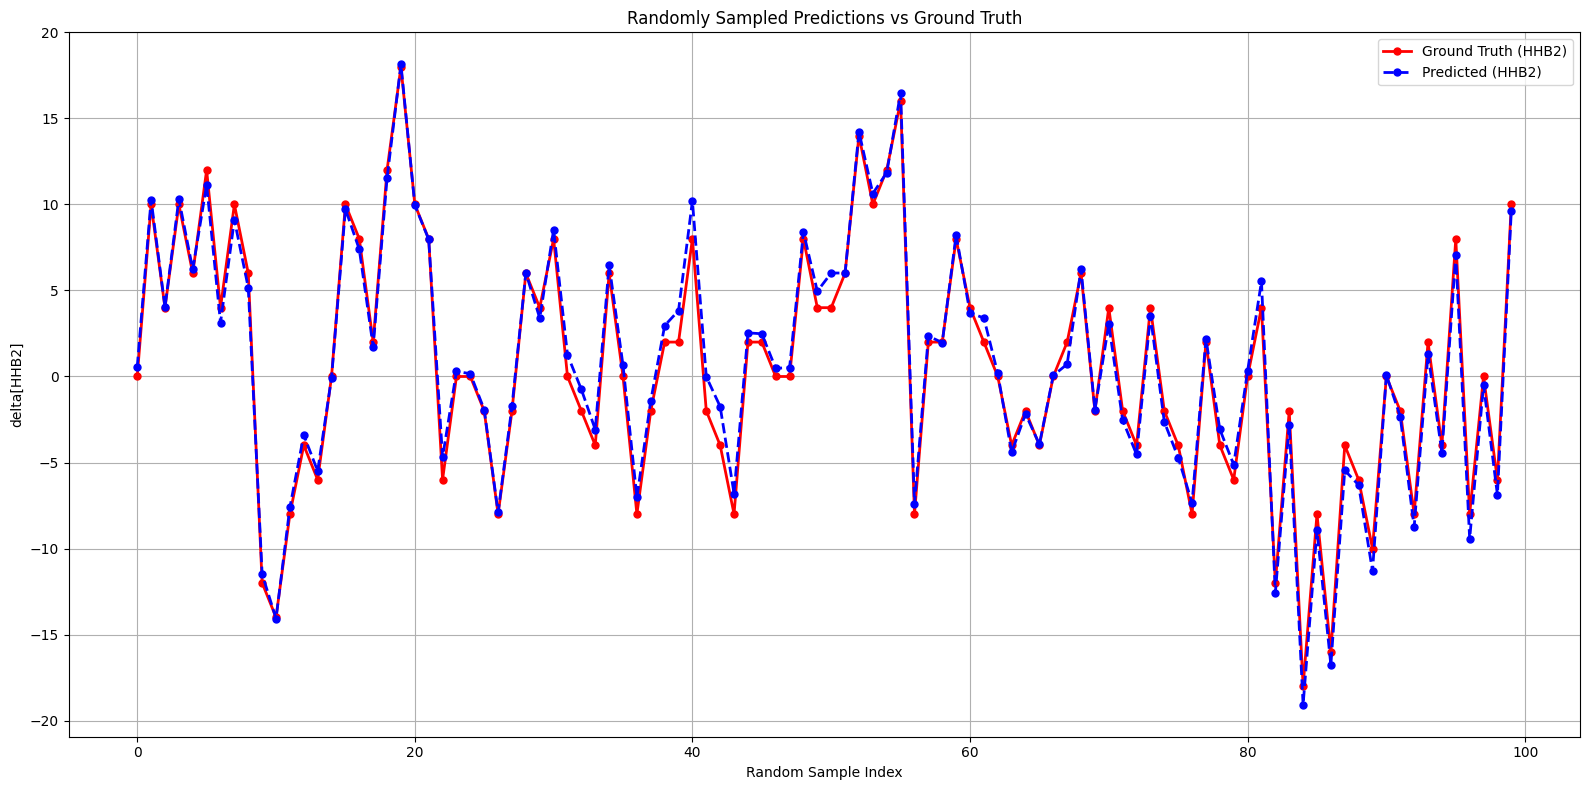

In [28]:
#y_pred = model.predict(X_test_s)

# Randomly select 100 indices
indices = np.random.choice(len(y_test_s), size=100, replace=False)
indices = np.sort(indices)

y_pred_rescaled = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
y_test_rescaled = scaler_y.inverse_transform(y_test_s.reshape(-1, 1)).flatten()

# Extract corresponding values
y_test_sampled = y_test_rescaled[indices]
y_pred_sampled = y_pred_rescaled[indices]

# Plot with circular markers
plt.figure(figsize=(16, 8))
plt.plot(y_test_sampled, 'r-o', label='Ground Truth (HHB2)', linewidth=2, markersize=5)
plt.plot(y_pred_sampled, 'b--o', label='Predicted (HHB2)', linewidth=2, markersize=5)
plt.xlabel('Random Sample Index')
plt.ylabel('delta[HHB2]')
plt.title('Randomly Sampled Predictions vs Ground Truth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Test MSE (original scale): 0.5816


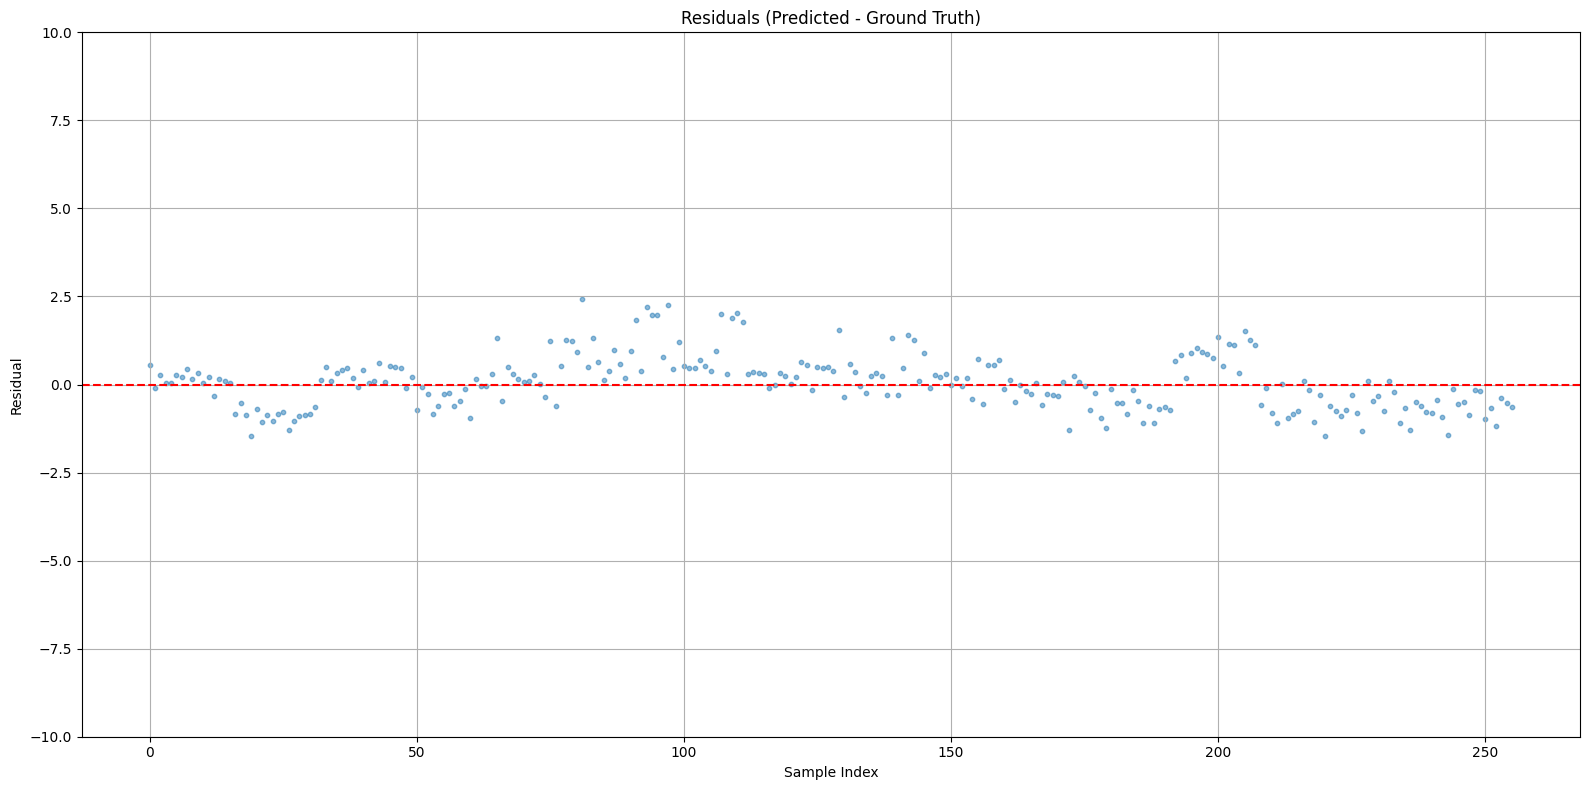

In [29]:
# Inverse-transform predictions and ground truth
y_pred_orig = scaler_y.inverse_transform(y_pred)       # shape (n, 1)
y_test_orig = scaler_y.inverse_transform(y_test_s)     # shape (n, 1)

# Compute residuals in original scale
residuals = y_pred_orig - y_test_orig

mse_rescaled = mean_squared_error(y_test_orig, y_pred_orig)
print(f"Test MSE (original scale): {mse_rescaled:.4f}")

# Plot residuals
plt.figure(figsize=(16, 8))
plt.scatter(range(len(residuals)), residuals, s=10, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.title("Residuals (Predicted - Ground Truth)")
plt.ylabel("Residual")
plt.ylim(-10, 10)
plt.xlabel("Sample Index")
plt.grid(True)
plt.tight_layout()
plt.show()

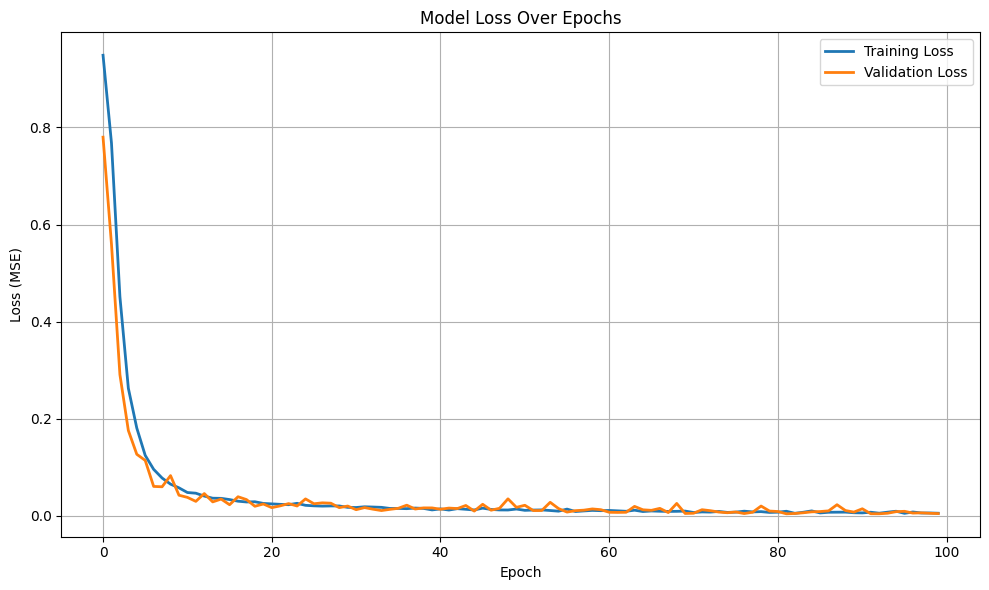

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
